First derivative, 3-layer CNN, relu activation, multistage

In [177]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime

In [178]:
torch.cuda.is_available()

True

In [179]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [180]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset using the second derivative instead of the first

The code currently loads a previously created dataset instead of creating a new one each time.

In [181]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives, self.second_derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        first_derivatives = []
        second_derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

            d2y_dx2 = torch.autograd.grad(outputs=dy_dx, inputs=self.x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
            second_derivatives.append(d2y_dx2.detach().numpy())

        return np.array(functions), np.array(first_derivatives), np.array(second_derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx]), torch.FloatTensor(self.second_derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000

# Uncomment below to create dataset
# dataset = FourierSeriesDataset(num_samples, num_points)

# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'datasets/both_derivatives_dataset.pt')

## Load previously saved dataset

In [182]:
# # When using the workstation:
dataset = torch.load('datasets/both_derivatives_dataset.pt')

# # When using the cluster:
# dataset = torch.load('both_derivatives_dataset.pt')

In [183]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [184]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [185]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


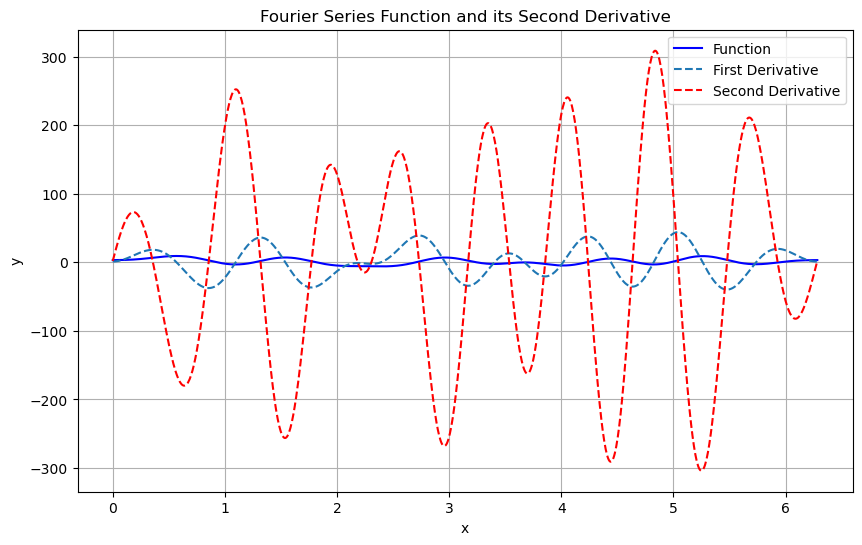

In [186]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative, second_derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()
    second_derivative = second_derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    plt.plot(x, second_derivative, label='Second Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Second Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset, shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

This version of the CNN uses three layers.

In [187]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model1 = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

In [188]:
# to use model from cluster, use
model1.load_state_dict(torch.load('models/first_stage_1000epochs_weights.pth'))

<All keys matched successfully>

## Training loop

In [189]:
# Training loop
train_losses = []
test_losses = []

def model_training(num_epochs, order=None):
    for epoch in range(num_epochs):
        model1.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives, batch_second_derivatives in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)
            batch_second_derivatives = batch_second_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model1(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model1.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives, b_test_second_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)
                b_test_second_derivatives = b_test_second_derivatives.unsqueeze(1)

                test_outputs = model1(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")

In [190]:
# Uncomment below to train and save the model
# model_training(10, order='first')
# torch.save(model1.state_dict(), 'models/E1000_D1_3L_AFrelu_1S.pth')

In [191]:
def plot_losses(train_losses, test_losses, save_dir='plots', xmin=None, ymax=None, filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

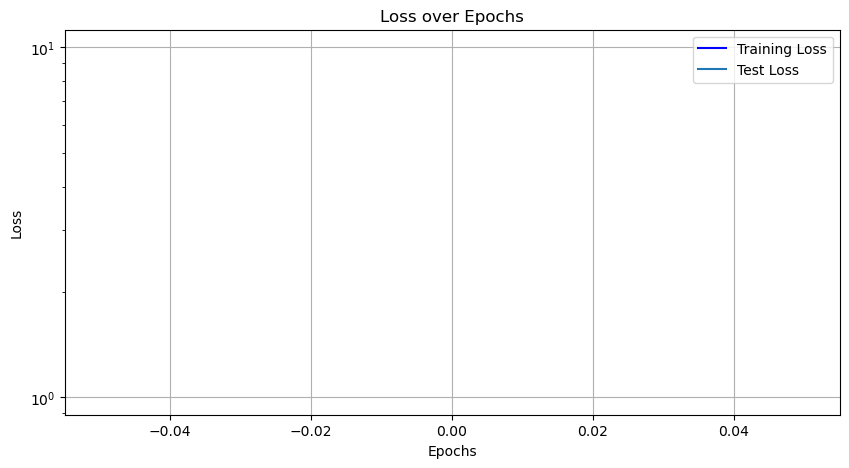

In [192]:
# plot_losses(train_losses=train_losses, test_losses=test_losses, filename='D1_3L_AFrelu_1S_loss', save=True)

In [193]:
def plot_output(model1, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset=train_dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative, true_second_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()
    true_second_derivative = true_second_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')
    if order == 2:
        plt.plot(x, true_second_derivative, label=f'True {order}nd derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

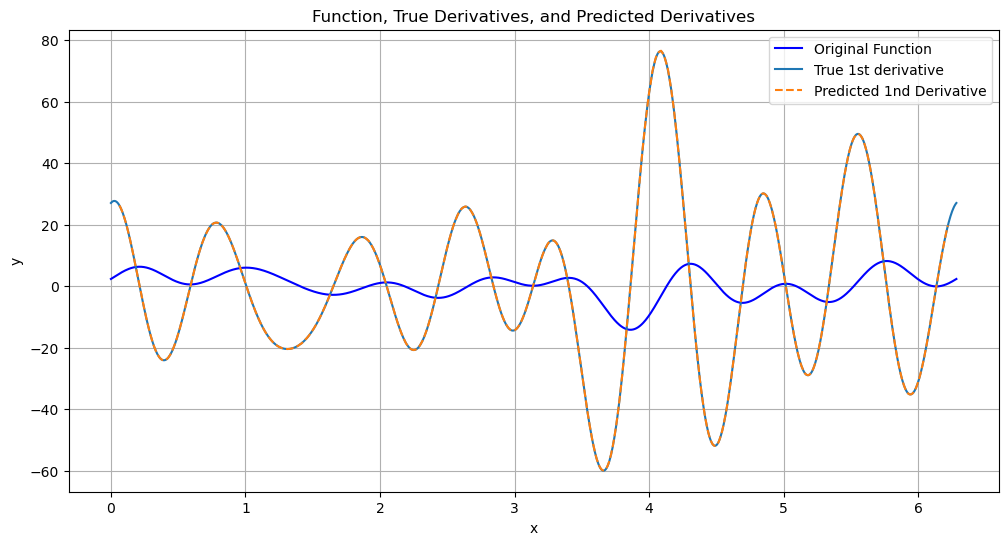

In [194]:
plot_output(model1, order=1, save_dir='plots', filename='D1_3L_AFrelu_1S_output', save=True)

## Calculate accuracy (MSE)

MSE is computed as: $\frac{1}{n} \sum (y-f(x))^2$

In [195]:
def calculate_combined_output(model1, model2, function_input, true_derivative):
    # Predict the derivative from the first model
    output = model1(function_input)

    # Compute the residual and root mean squared error
    residual = output.squeeze() - true_derivative
    rms = torch.sqrt(torch.mean(residual**2))

    # Predict the derivative from the second model
    output2 = model2(function_input)

    # Calculate the combined model output
    combined_model_output = output + rms * output2

    return combined_model_output

In [196]:
def compute_mse(dataset, model1, model2=None):
    all_outputs = []
    all_targets = []

    dataloader = DataLoader(dataset)
    for function, deriv, second_deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)
        second_deriv = second_deriv.unsqueeze(1)

        # Compute model output
        if model2:
            model_output = calculate_combined_output(model1, model2, function, deriv)
            all_targets.append(deriv)
        else:
            model_output = model1(function)
            all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2)
    # print(f"Overall MSE over all test functions: {mse.item()}")
    return mse.item()

print(f"MSE over all functions: {compute_mse(test_dataset, model1)}")

MSE over all functions: 0.002187057863920927


## Normalized MSE

NMSE is computed as: $\frac{1}{n} \frac{\sum (y-f(x))^2}{\sum y^2}$

In [222]:
def compute_nmse(dataset, model1, model2=None):
    all_outputs = []
    all_targets = []

    dataloader = DataLoader(dataset)
    for function, deriv, second_deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)
        second_deriv = second_deriv.unsqueeze(1)

        # Compute model output
        if model2:
            model_output = calculate_combined_output(model1, model2, function, deriv)
            all_targets.append(deriv)
        else:
            model_output = model1(function)
            all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2)
    normalizing_factor = torch.mean(all_targets ** 2)

    nmse = mse / normalizing_factor

    # print(f"Overall NMSE over all test functions: {nmse.item()}")
    return nmse.item()
print(f"NMSE over all functions: {compute_nmse(test_dataset, model1)}")

NMSE over all functions: 9.15424243430607e-06


## Spectral biases from Fourier Transform

In [198]:
def calculate_median_frequency(function):
    fft_coeffs = np.fft.fft(function)
    freqs = np.fft.fftfreq(len(function))
    power_spectrum = np.abs(fft_coeffs)**2
    significant_freqs = freqs[power_spectrum > (np.max(power_spectrum) * 0.01)]
    return np.median(np.abs(significant_freqs))

def categorize_functions(dataloader):
    functions_with_freqs = []
    
    for functions, derivatives, sec_derivative in dataloader:
        for idx, function in enumerate(functions):
            median_frequency = calculate_median_frequency(function.numpy())
            functions_with_freqs.append((function.numpy(), derivatives[idx].numpy(), sec_derivative[idx].numpy(), median_frequency))
    
    # Sort by median frequency
    functions_with_freqs.sort(key=lambda x: x[3])
    
    # Split into low and high frequency datasets
    mid_index = len(functions_with_freqs) // 2
    low_freq_dataset = functions_with_freqs[:mid_index]
    high_freq_dataset = functions_with_freqs[mid_index:]
    
    # Create new DataLoaders, excluding the median frequency from the data
    # Each dataloader contains the function, deriv, and second deriv
    low_freq_dataloader = [(f[0], f[1], f[2]) for f in low_freq_dataset]
    high_freq_dataloader = [(f[0], f[1], f[2]) for f in high_freq_dataset]
    
    return low_freq_dataloader, high_freq_dataloader

In [199]:
# use the test dataset to compute frequencies
# Should be half of full dataset in each dataloader
low_freq_dataset, high_freq_dataset = categorize_functions(test_dataloader)

print(f"Low frequency dataset size: {len(low_freq_dataset)}")
print(f"High frequency dataset size: {len(high_freq_dataset)}")

Low frequency dataset size: 992
High frequency dataset size: 992


In [200]:
print(f"MSE over low freq functions: {compute_mse(low_freq_dataset, model1)}")
print(f"NMSE over low freq functions: {compute_nmse(low_freq_dataset, model1)}")

MSE over low freq functions: 0.0007985029951669276
NMSE over low freq functions: 1.761580460879486e-05


In [201]:
print(f"MSE over high freq functions: {compute_mse(high_freq_dataset, model1)}")
print(f"NMSE over high freq functions: {compute_nmse(high_freq_dataset, model1)}")

MSE over high freq functions: 0.0035866843536496162
NMSE over high freq functions: 8.288456228910945e-06


### Plotting errors

In [215]:
def plot_difference(model1, dataset, save_dir='plots', filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model1.eval()  # Set the model to evaluation mode

    def plot_sliced(x, y, label, linestyle='-'):
        plt.plot(x[10:-10], y[10:-10], label=label, linestyle=linestyle)

    plt.figure(figsize=(12, 12))  # Adjust figure size for a 2x2 grid
    
    for i in range(1, 5):  # Loop over four different functions
        train_dataloader_viz = get_random_function(dataset, shuffle=True)
        dataiter = iter(train_dataloader_viz)
        function, true_derivative, true_second_derivative = next(dataiter)

        function = function.unsqueeze(1)  # Add channel dimension

        # Make prediction
        with torch.no_grad():
            predicted_derivative = model1(function)
            first_deriv_diff = true_derivative - predicted_derivative

            predicted_second_derivative = model1(predicted_derivative)
            second_deriv_diff = true_second_derivative - predicted_second_derivative

        # Convert tensors to numpy arrays for plotting
        x = torch.linspace(0, 2*torch.pi, 1000).numpy()
        function = function.squeeze().numpy()
        true_derivative = true_derivative.squeeze().numpy()
        true_second_derivative = true_second_derivative.squeeze().numpy()
        
        first_deriv_diff = first_deriv_diff.squeeze().numpy()
        second_deriv_diff = second_deriv_diff.squeeze().numpy()

        plt.subplot(2, 2, i)  # Adjust subplot position
        plot_sliced(x, function, '$u$')
        plot_sliced(x, first_deriv_diff, "$u'_g - u'_{\\theta}$", linestyle='--')
        # plot_sliced(x, true_derivative, "$u'_g$")
        # plot_sliced(x, true_second_derivative, "$u''_g$", linestyle='--')

        plt.title(f'Difference for Function {i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

        mse = np.mean((first_deriv_diff) ** 2)
        nmse = mse / np.mean(true_derivative ** 2)

        print(f"MSE for function {i} is: {mse}")        
        print(f"NMSE for function {i} is: {nmse}\n")        

    if save:
        save_path = os.path.join(save_dir, filename if filename else 'multi_plot.png')
        plt.savefig(save_path)
    plt.show()


MSE for function 1 is: 0.0003825524472631514
NMSE for function 1 is: 9.92174773273291e-06

MSE for function 2 is: 0.002697884337976575
NMSE for function 2 is: 6.721387035213411e-05

MSE for function 3 is: 0.0006792193744331598
NMSE for function 3 is: 3.801163529715268e-06

MSE for function 4 is: 0.0012642850633710623
NMSE for function 4 is: 5.072540716355434e-06



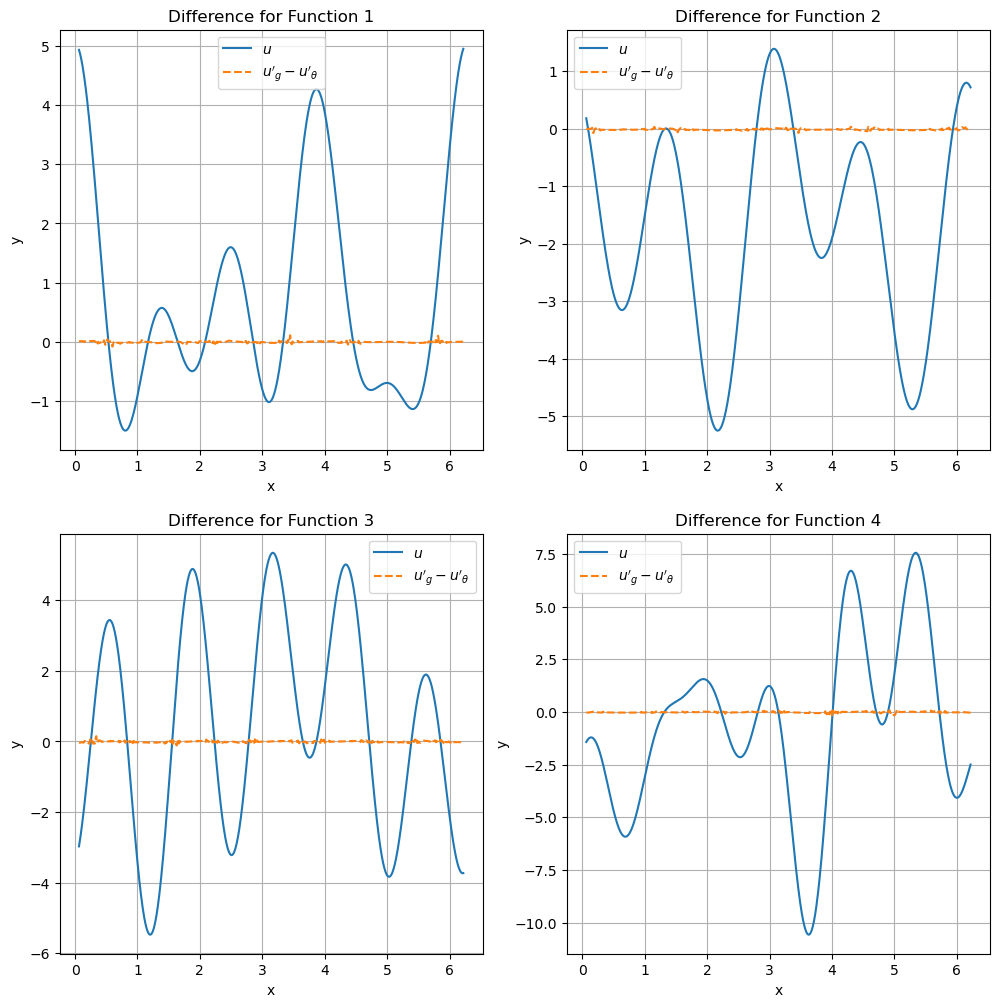

In [216]:
plot_difference(model1, dataset=low_freq_dataset, save_dir='plots', filename='D1_3L_AFrelu_1S_lowf', save=True)

MSE for function 1 is: 0.0011257498990744352
NMSE for function 1 is: 1.0988768735842314e-05

MSE for function 2 is: 0.0015251445583999157
NMSE for function 2 is: 5.220415005169343e-06

MSE for function 3 is: 0.001527944696135819
NMSE for function 3 is: 2.187541895182221e-06

MSE for function 4 is: 0.0017503498820587993
NMSE for function 4 is: 3.4521303859946784e-06



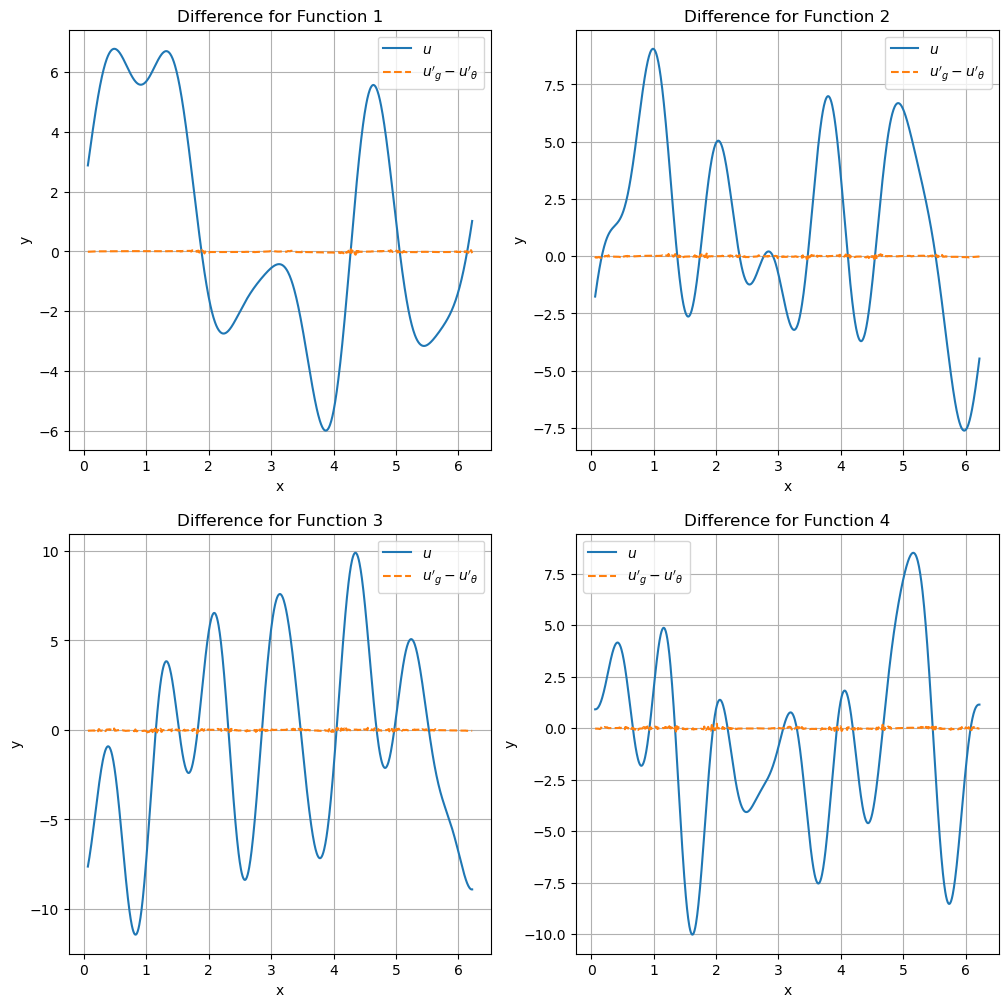

In [217]:
plot_difference(model1, dataset=high_freq_dataset, save_dir='plots', filename='D1_3L_AFrelu_1S_highf', save=True)

## Second stage training

In [205]:
class ResidualDataset(Dataset):
    def __init__(self, original_dataset, residuals):
        self.original_dataset = original_dataset
        self.residuals = residuals

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        function, _, _ = self.original_dataset[idx]
        return function, self.residuals[idx]

        # will need to modify this to include the second derivative at some point

In [206]:
def compute_normalized_residual(model, dataloader):
    model.eval() # model1 is the trained first stage network
    residuals = []
    with torch.no_grad():
        for function, derivative, second_derivative in dataloader:
            function = function.unsqueeze(1)
            outputs = model(function) # compute the first stage network outputs
            
            outputs = outputs.squeeze() # remove the extra batch dimension after model has computed outputs
            residual = outputs - derivative # computing the difference between predicted derivative and true first derivative
            # residual is a vector that should have shape 32,1000
            residuals.append(residual)
            
    residuals = torch.cat(residuals, dim=0)
    # print(f"Residuals: {residuals[0]}")
    rms = torch.sqrt(torch.mean(residuals**2))
    print(f"rms: {rms}")
    normalized_residuals = residuals / rms
    return normalized_residuals, rms

Compute normalized residuals

In [207]:
# use the first stage network ("model" corresponds to the first stage of training)
train_residuals, train_rms = compute_normalized_residual(model1, train_dataloader)
test_residuals, test_rms = compute_normalized_residual(model1, test_dataloader)

# Create residual datasets: contains the original functions and their residuals from the first stage
residual_train_dataset = ResidualDataset(train_dataset, train_residuals)
residual_test_dataset = ResidualDataset(test_dataset, test_residuals)

# Create dataloaders for residual data
residual_train_dataloader = DataLoader(residual_train_dataset, batch_size=32, shuffle=True, drop_last=True)
residual_test_dataloader = DataLoader(residual_test_dataset, batch_size=32, shuffle=False, drop_last=True)

rms: 0.05049818381667137
rms: 0.04682513326406479


In [208]:
second_stage_model = SimpleCNN()
residual_optimizer = optim.Adam(second_stage_model.parameters())

In [209]:
def second_stage_model_training(model, num_epochs, order=None):

    model = second_stage_model
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        # no batch_second_derivatives in residual_train_dataloader
        for batch_functions, batch_derivatives in residual_train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives) # criterion still MSE

            # backward pass
            residual_optimizer.zero_grad()
            loss.backward()
            residual_optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in residual_test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)
                # b_test_second_derivatives = b_test_second_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")
    return train_losses, test_losses

In [210]:
second_stage_train_losses, second_stage_test_losses = second_stage_model_training(second_stage_model, 1000, order='first')
torch.save(second_stage_model.state_dict(), 'models/E1000_D1_3L_AFrelu_2S.pth')

Epoch [1/10], Train Loss: 0.9762, Test Loss: 0.9654
Epoch [2/10], Train Loss: 0.9742, Test Loss: 0.9746
Epoch [3/10], Train Loss: 0.9737, Test Loss: 0.9717
Epoch [4/10], Train Loss: 0.9734, Test Loss: 0.9617
Epoch [5/10], Train Loss: 0.9732, Test Loss: 0.9787
Epoch [6/10], Train Loss: 0.9730, Test Loss: 0.9732
Epoch [7/10], Train Loss: 0.9729, Test Loss: 0.9608
Epoch [8/10], Train Loss: 0.9726, Test Loss: 0.9680
Epoch [9/10], Train Loss: 0.9725, Test Loss: 0.9695
Epoch [10/10], Train Loss: 0.9725, Test Loss: 0.9741
Training finished for second derivative


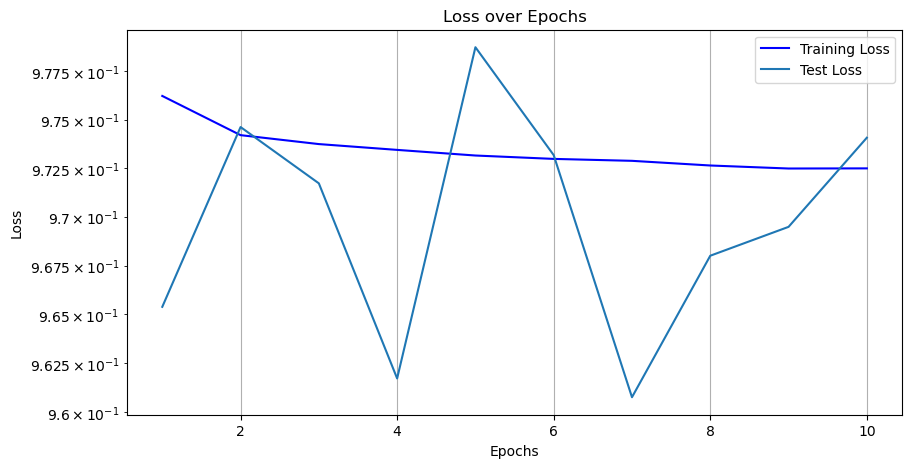

In [218]:
plot_losses(train_losses=second_stage_train_losses, test_losses=second_stage_test_losses, filename='second_stage_loss', save=True)

In [220]:
print(f"Second stage MSE over all functions: {compute_mse(test_dataset, model1, second_stage_model)}")
print(f"Second stage MSE over low freq functions: {compute_mse(low_freq_dataset, model1, second_stage_model)}")
print(f"Second stage MSE over high freq functions: {compute_mse(high_freq_dataset, model1, second_stage_model)}\n")

Second stage MSE over all functions: 0.0023406161926686764
Second stage MSE over low freq functions: 0.0008838176145218313
Second stage MSE over high freq functions: 0.003808797337114811



In [224]:
print(f"Second stage NMSE over all functions: {compute_nmse(test_dataset, model1, second_stage_model)}")
print(f"Second stage NMSE over low freq functions: {compute_nmse(low_freq_dataset, model1, second_stage_model)}")
print(f"Second stage NMSE over high freq functions: {compute_nmse(high_freq_dataset, model1, second_stage_model)}")

Second stage NMSE over all functions: 9.7969832495437e-06
Second stage NMSE over low freq functions: 1.9497932953527197e-05
Second stage NMSE over high freq functions: 8.80173593031941e-06
